In [1]:
import numpy as np 
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import torch.nn as nn



C:\Users\kosty\anaconda3\envs\nn_diploma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install transformers

In [3]:
if torch.cuda.is_available():
    # Get GPU device name
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
else:
    print(":( no gpu for u)")

GPU: NVIDIA GeForce RTX 4070


In [4]:
import gc
torch.cuda.empty_cache()
gc.collect()

86

In [5]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
# tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): La

In [6]:
id_checkers=['()','[','&', '$', '{', '}', '\\', '^']
for item in id_checkers:
    print(tokenizer.vocab[item])

43048
10975
947
1629
45152
24303
37457
35227


In [7]:
# # ОКАЗЫВАЕТСЯ есть проблемы со скобками. и возможно чем-то ещё. пока вот так
# new_words = ['{', '}','^','\\']
# # понять что тут произошло
# # BPE-токенизация (?)
# tokenizer.add_tokens(new_words)

# model.resize_token_embeddings(len(tokenizer))

In [8]:
for item in id_checkers:
    print(tokenizer.vocab[item])
# for item in new_words:
#     print(tokenizer.vocab[item])

43048
10975
947
1629
45152
24303
37457
35227


In [9]:
df_l = pd.read_parquet('FIRST_PROPER_DF.parquet', engine='pyarrow').sample(frac=1)

In [10]:
df= df_l.head(300000)

In [11]:
df.sample(10)

,output_texts,input_texts,tags
30653,Рассмотрим проекцию $X \to S^2$ на первую комп...,Рассмотрим проекцию $ икс заглавный \rightar...,"['general-topology', 'algebraic-topology', 'qu..."
141292,Ваш базовый случай будет просто $n=1$. Это дов...,Ваш базовый случай будет просто $n=1$. Это дов...,"['induction', 'modular-arithmetic', 'congruenc..."
145896,"Другой подход, если вы рассмотрели непрерывные...","Другой подход, если вы рассмотрели непрерывные...","['general-topology', 'proof-verification', 'me..."
167861,$\eta(\sum_i a_i\otimes b_i)\ne \eta(\sum_i c_...,$\eta(\suw_ итая a_ итая \otimes бэ _ ай с...,None
48834,Производная *является* предельной формулой. Бо...,Производная *является* предельной формулой. Бо...,['calculus']
211756,$$\sum_{i=1}^na_i^2\sum_{i=1}^nb_i^2\geq\left(...,$$ сумфа от {i ргвняется 1}^na_ ай в степени2...,None
292338,\begin{align}\r\n&\int\arccos\pars{\root{x + 1...,\begin{align}\r\n&\int\arccws\pars{\rootЯ х ...,None
64911,Если под наклонным цилиндром вы подразумеваете...,Если под наклонным цилиндром вы подразумеваете...,"['geometry', 'parametrization', 'solid-geometr..."
14920,"> Я знаю, что $E[X\mid Y]$ можно определить ка...","> Я знаю, что $ и заглавная [ Х \mid игрек бо...","['probability', 'probability-theory', 'proof-w..."
64936,"Мы имеем дело с полиномами пятой степени, т.е....","Мы имеем дело с полиномами пятой степени, т.е....","['linear-algebra', 'vector-spaces']"


In [12]:
# понять какой maxlen ставить
med_len = df['output_texts'].str.len().median()//2
med_len

79.0

In [13]:
# maxlen посмотреть по медиане (или около того) длины
# maxlen поменьше, батчсайз побольше
# 
# rapid fuzz? (lib) -- normalized edit distance 
# ф -- f?
# \phi, \varphi --> ф
# эй би си 
# а бэ цэ
# p --> п пэ
# \pi --> пи п
# ^ \sum_{}в степени{} --> ^ 
# python
# pip install rapidfuzz -- для нормализованного расстояния левенштейна, брать отсюда


# удалил .to(device) -- ДА
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=int(med_len)):
        df.reset_index(drop=True, inplace=True)
        self.outputs = df["output_texts"]
        self.inputs = df["input_texts"]
        self.tokenizer = tokenizer
        self.max_len=max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        item = {}
        inputs = self.tokenizer(self.inputs[index],return_tensors='pt',
                                padding='max_length',truncation=True,
                                return_attention_mask=True,max_length=self.max_len)
        outputs = self.tokenizer(self.outputs[index],return_tensors='pt',
                                 padding='max_length',truncation=True, 
                                 return_attention_mask=True,max_length=self.max_len)
        
        item['input_ids'] = inputs['input_ids'].squeeze().to(device)
        item['attention_mask'] = inputs['attention_mask'].squeeze().to(device)
        item['labels'] = outputs['input_ids'].squeeze().to(device)
        return item

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
from rapidfuzz.distance import Levenshtein

In [16]:
df.sample(5)

,output_texts,input_texts,tags
124933,* Вычислить периметр $P$: $P=2r+\theta r =r(2+...,* Вычислить периметр $P$: $ пэ прописная =2r п...,"['geometry', 'trigonometry', 'optimization', '..."
302109,$$\sqrt{1+x^2}-x=1-x+\frac{x^2}{2}+O\left(x^3\...,$$ квадратный корень из {1+ хэ в степени 2}- ...,None
261286,$$|h(z)|=|e^{Re(if^2(z))}\cdot e^{i\cdot Im(if...,$$|h( зет скобказакрываевся | равно Я и в ст...,None
99397,Рассмотрим $h(x) = f(x) - g(x).$\nУсловия этог...,Рассмотрим $h(x) = f(x) - g(x).$\nУсловия этог...,['real-analysis']
186333,$$F(\omega) = \mathcal{F}(e^{-at}u(t))\cdot\ma...,$$ эф большая скобки открываю тся омега стро...,None


In [17]:
import matplotlib.pyplot as plt

In [18]:
df.reset_index(inplace=True,drop=True)

In [19]:
df.head(3)

,output_texts,input_texts,tags
0,$f(a) = f(2a^2) = f(2(2a^2)^2) = f(2(2(2a^2)^2...,$ фэ ( а скобки закрываются равняется эф в...,None
1,"Если $f(m,n)=f(n,m)$, по симметрии\r\n$$\sum_{...","Если $ эф ( эм , эн скобки закрываются = эф (...","['number-theory', 'homology-cohomology', 'zeta..."
2,$$ \r\n2\left(ab+ac+bc\right) \r\n\leq \r\n2\l...,$$ \r\n2\left(ab+ac+bc\right) \r\n \leqslant ...,None


In [20]:
from ast import literal_eval

In [24]:
# находим уникальные теги
def get_unique_tags(df):
    uniques={}
    for tags in zip(df['tags']):
        # tags это тьюплы с одним элементом -- листом в виде строки
        # т.ч. сначала эту строку достаём
        # а потом literal_eval для того чтобы это было уже норм листом
        #print(tags[0])
        for tag in tags[0]:
            if tag in uniques:
                uniques[tag]+=1
            else: uniques[tag]=1
    return uniques

In [25]:
un=get_unique_tags(df)
len(un)

TypeError: 'NoneType' object is not iterable

In [23]:
# если хотя бы в 2% записей этот тэг есть
major_tags={key:value for key,value in un.items() if value>(len(df)/50)}

NameError: name 'un' is not defined

In [25]:
major_tags

{'None': 169967,
 'probability': 8142,
 'sequences-and-series': 7111,
 'linear-algebra': 10880,
 'real-analysis': 13785,
 'limits': 6055,
 'calculus': 14248,
 'integration': 6609}

In [26]:
from statistics import median, mean

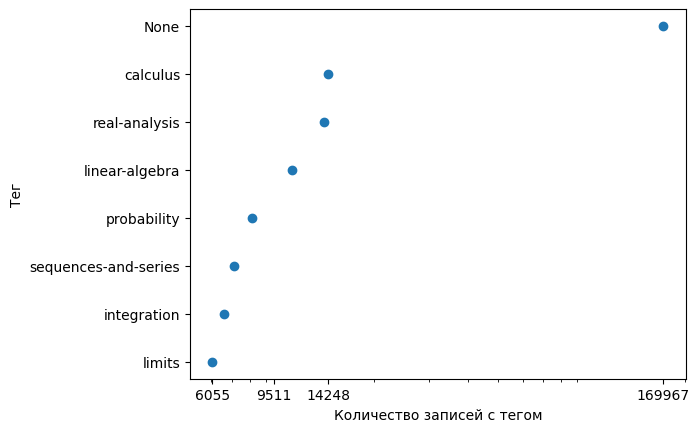

In [27]:
lists = sorted(major_tags.items(),key=lambda x:x[1]) 

y, x = zip(*lists)

fig, ax = plt.subplots()
ax.yaxis.set_tick_params(labelsize=10) 
plt.scatter(x, y)
plt.xlabel('Количество записей с тегом')
plt.ylabel('Тег')
plt.xscale('log')
ticks = [min(major_tags.values()),round(median(major_tags.values())), lists[-2][1], max(major_tags.values())] 
tick_labels = [f'{val}' for val in ticks]

plt.xticks(ticks, tick_labels)
plt.show()

In [28]:
# и как тут проводить стратификацию......
# можно сделать по наиболее используемым тегам?
# создавать 1160 колонок как-то неоч...
# да даже одну с 1160 значениями...

In [29]:
# можно заметить что отсутствие тэгов - наиболее популярная опция
# дальше по встречаемости - вопросы по матану, вещественному анализу, линалу и вероятностям
# первых тэгов у нас значительно меньше
# т.ж. можно заметить, что много тегов у которых 1-2 использования
# из разряда 'book reommendations'
# в целом можно сделать так
# None --> оставить None
# если первый тэг в списке наиболее популярных (ну пусть >150 использований)
# то оставлять его 
#(в колонке будет 
#df['tags']=df['tags'].apply(prepare_tags_for_stratification, args=(popular_taglist))
# а если нет --> тэгать как 'Other'

# в итоге сделал не с первым тегом а в целом с любым из существующих

In [30]:
major_tags

{'None': 169967,
 'probability': 8142,
 'sequences-and-series': 7111,
 'linear-algebra': 10880,
 'real-analysis': 13785,
 'limits': 6055,
 'calculus': 14248,
 'integration': 6609}

In [31]:
def reassign_tags(line, major_tags):
    line = literal_eval(line)
    
    # если тегов нет
    if not line:
        return 'None'
    
    # смотрим есть ли у нас хотя бы один популярный тег
    populars = set(line).intersection(major_tags.keys())
    
    # если нет то тегаем как 'Другое'
    if not populars:
        return 'Other'
    # а если да - тегаем Самым популярным
    else:
        most_popular = max(populars, key=lambda tag: major_tags[tag])
        return most_popular


In [32]:
df['tags'] = df['tags'].apply(reassign_tags, args=[major_tags])

C:\Users\kosty\AppData\Local\Temp\ipykernel_11664\1172564249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tags'] = df['tags'].apply(reassign_tags, args=[major_tags])


In [33]:
df.sample(10)

,output_texts,input_texts,tags
138618,"Что вы можете сказать, так это то, что правиль...","Что вы можете сказать, так это то, что правиль...",integration
186653,*Намекать*\r\n\r\nПопробуйте использовать $n$ ...,*Намекать*\r\n\r\nПопробуйте использовать $n$ ...,Other
176696,"$\newcommand{\bbx}[1]{\,\bbox[15px,border:1px ...",$\newcommand{\bbx} квадЦатная скобка 1 квадрат...,None
96891,$$I(n)+I(n)=\int^{\pi}_{0}\bigg[\ln(1-2n\cos x...,н$ ай большаяя ( эн скобки закрыв аются + ай ...,None
102077,Ваша фигура — *трапеция*. Но чтобы применить т...,Ваша фигура — *трапеция*. Но чтобы применить т...,integration
41199,$$\r\nx+5y+3z\r\n = \vec{u} \cdot \vec{v}\r\n ...,$$\r\n икс плюс 5 у плюс 3 зет \r\n равняет...,None
201831,>$\begin{bmatrix}Mv_1&Mv_2&...&Mv_n\end{bmatri...,>$\begin{bmatrix}Mv с индексом 1&Mv с индексом...,linear-algebra
40851,$$ f(t) = \left< A \left( \frac{v_1 + t w}{|v_...,$$ фэ ( т скообкизакрываются равняется l...,None
40080,Площадь кривой в полярных координатах равна $$...,Площадь кривой в полярных координатах равна $$...,integration
292465,\begin{align*}\r\nF(x) &= \frac{1+x}{1 - (1+x)...,\begin align*}\r\nF(x скобкка закрывается & р...,None


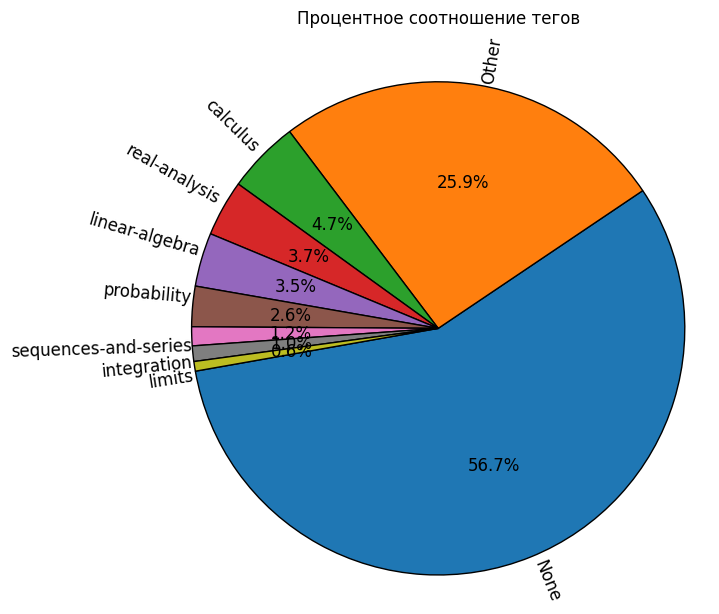

In [34]:
tag_counts = df['tags'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(tag_counts, labels=tag_counts.index, autopct='%1.1f%%', startangle=190,
        labeldistance=1,  textprops={'fontsize': 12}, rotatelabels=True,  wedgeprops={'edgecolor': 'black'})
plt.title('Процентное соотношение тегов', y=1.05)
plt.axis('equal')
plt.show()

In [35]:
# делим 80/15/5
train_dataset, test_dataset = train_test_split(df, 
                                               test_size=0.05,
                                               stratify=df['tags'] ,
                                               random_state=1)
train_dataset, val_dataset = train_test_split(train_dataset,
                                              test_size=0.1425, 
                                              stratify=train_dataset['tags'],
                                              random_state=1)

print("Training data size: {}".format(len(train_dataset)))
print("Validation data size: {}".format(len(val_dataset)))
print("Testing data size: {}".format(len(test_dataset)))


Training data size: 244387
Validation data size: 40613
Testing data size: 15000


In [36]:
train_dataset.head()

,output_texts,input_texts,tags
190909,$$\r\n0\le \sum_{n\geq 1}\frac{\log(n)}{n^2}\l...,т$\r\n0\lee\sum_{ эн \geq1}дробь от \log( эн )...,None
273010,Я хочу предложить альтернативу. Мы согласны с ...,Я хочу предложить альтернативу. Мы согласны с ...,Other
230551,"$\langle i\rangle=\{i, i^2,i^3,\ldots\}=\{i, -...",$ скобки открываютсяя i скобка закрываетХя р...,None
13409,Напишите $$m={4x^3\over 12x^2-1}$$\r\n\r\nПоэт...,Напишите $$m равняется {4 х в степени 3 over ...,calculus
223867,Если вы можете использовать китайскую теорему ...,Если вы можете использовать китайскую теорему ...,Other


In [37]:
train_dataset = CustomDataset(train_dataset, tokenizer)
test_dataset = CustomDataset(test_dataset, tokenizer)
val_dataset = CustomDataset(val_dataset, tokenizer)

In [38]:
for item in train_dataset[3]:
    print(item)
    print(len(train_dataset[3][item]))
   

input_ids
79
attention_mask
79
labels
79


In [39]:
BATCH_SIZE=40

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [40]:
from tqdm.auto import tqdm
from transformers import get_scheduler

In [41]:
%%time
# основная часть -- training/eval loops
epochs = 10
train_losses = []
val_losses = []
edit_scores = []

for epoch in range(epochs):
    # обучение
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'train epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'train loss: {avg_train_loss}')

    # валидация
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'val epoch {epoch + 1}/{epochs}'):
            #print(batch)
            for item in batch:
                batch[item]=batch[item].to(device)
            #print(batch)
            outputs = model(**batch)
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            
        val_loss = outputs.loss
        val_losses.append(val_loss.item())
    
    print(f'val loss: {val_loss.item()}')

train epoch 1/10:   0%|                                                                       | 0/6110 [00:00<?, ?it/s]C:\Users\kosty\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bart\modeling_bart.py:590: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
train epoch 1/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:16:18<00:00,  1.33it/s]


train loss: 0.584605840170442


val epoch 1/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [06:48<00:00,  2.49it/s]


val loss: 0.5264132022857666


train epoch 2/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:39<00:00,  1.40it/s]


train loss: 0.43711773973147333


val epoch 2/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:18<00:00,  2.32it/s]


val loss: 0.5243256092071533


train epoch 3/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:32<00:00,  1.40it/s]


train loss: 0.39898725960970705


val epoch 3/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:11<00:00,  2.35it/s]


val loss: 0.47331055998802185


train epoch 4/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:30<00:00,  1.40it/s]


train loss: 0.3741010154352055


val epoch 4/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:14<00:00,  2.34it/s]


val loss: 0.43072912096977234


train epoch 5/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:16<00:00,  1.41it/s]


train loss: 0.3546676444661013


val epoch 5/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:10<00:00,  2.36it/s]


val loss: 0.45214295387268066


train epoch 6/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:26<00:00,  1.41it/s]


train loss: 0.3383107396687111


val epoch 6/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:12<00:00,  2.35it/s]


val loss: 0.40995100140571594


train epoch 7/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:30<00:00,  1.40it/s]


train loss: 0.32308503612022355


val epoch 7/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:15<00:00,  2.34it/s]


val loss: 0.3952564597129822


train epoch 8/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:41<00:00,  1.40it/s]


train loss: 0.3089953636845083


val epoch 8/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:14<00:00,  2.34it/s]


val loss: 0.43113014101982117


train epoch 9/10: 100%|██████████████████████████████████████████████████████████| 6110/6110 [1:12:31<00:00,  1.40it/s]


train loss: 0.2953640388754698


val epoch 9/10: 100%|██████████████████████████████████████████████████████████████| 1016/1016 [07:14<00:00,  2.34it/s]


val loss: 0.3882189989089966


train epoch 10/10: 100%|█████████████████████████████████████████████████████████| 6110/6110 [1:12:30<00:00,  1.40it/s]


train loss: 0.28248160531936417


val epoch 10/10: 100%|█████████████████████████████████████████████████████████████| 1016/1016 [07:15<00:00,  2.33it/s]

val loss: 0.44887426495552063
CPU times: total: 3h 36min 2s
Wall time: 13h 20min 56s


In [42]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [43]:
output_dir = "/kaggle/working/finetuned_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/kaggle/working/finetuned_model\\tokenizer_config.json',
 '/kaggle/working/finetuned_model\\special_tokens_map.json',
 '/kaggle/working/finetuned_model\\vocab.json',
 '/kaggle/working/finetuned_model\\merges.txt',
 '/kaggle/working/finetuned_model\\added_tokens.json',
 '/kaggle/working/finetuned_model\\tokenizer.json')

In [44]:
import shutil
shutil.make_archive('ft_mod', 'zip', output_dir)

'C:\\Users\\kosty\\ft_mod.zip'

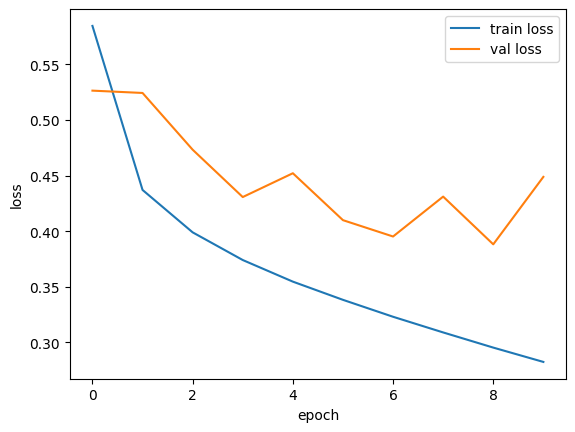

In [45]:
from matplotlib import pyplot as plt
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [46]:
%%time

model.eval()
model.to('cuda')

test_metrics = []
hyps = []
all_preds=[]
with torch.no_grad():
    for batch in tqdm(test_loader, desc='testing'):
        batch['input_ids']=batch['input_ids'].to('cuda')
        phrases = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        hypotheses = []
        
        for tens_to_be, phrase in zip(batch['input_ids'],phrases):
            max_len = len(phrase)

            one_pred = model.generate(
                tens_to_be.unsqueeze(0),
                do_sample=True, 
                top_p=0.95, 
                num_return_sequences=1, 
                repetition_penalty=2.2,
                max_length=max_len 
            )
            hyps.append(one_pred.tolist()[0])
        hyps = tokenizer.batch_decode(hyps, skip_special_tokens=True)

        all_preds.append(hyps)
        for generated, label in zip(hyps, phrases):
            metric = Levenshtein.normalized_similarity(generated, label)
            test_metrics.append(metric)
        hyps=[]

print(test_metrics)


testing:   0%|                                                                                 | 0/375 [00:00<?, ?it/s]C:\Users\kosty\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1158: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (50). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
C:\Users\kosty\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1158: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (51). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
testing:   0%|▏                                                                      | 1/375 [00:17<1:48:59, 17.49s/it]C:\Users\kosty\AppData\Local

[0.5604395604395604, 0.9883720930232558, 0.7857142857142857, 0.9222222222222223, 0.8493150684931507, 0.3893129770992366, 0.4285714285714286, 0.5625, 0.8405797101449275, 0.43518518518518523, 0.46846846846846846, 0.4505494505494505, 0.5308641975308642, 0.28971962616822433, 0.5555555555555556, 0.28181818181818186, 0.7254901960784313, 0.863013698630137, 0.7051282051282051, 0.7123287671232876, 0.5165562913907285, 0.6115702479338843, 0.35416666666666663, 0.6274509803921569, 0.6785714285714286, 0.6068376068376069, 0.4651162790697675, 0.578512396694215, 0.5714285714285714, 0.22123893805309736, 0.7878787878787878, 0.4044943820224719, 0.7238095238095238, 0.6666666666666667, 0.6507936507936508, 0.30487804878048785, 0.6415094339622642, 0.26016260162601623, 0.4408602150537635, 0.9189189189189189, 0.5789473684210527, 0.5571428571428572, 0.7424242424242424, 0.8088235294117647, 0.4461538461538461, 0.691358024691358, 0.48913043478260865, 0.6018518518518519, 0.4260869565217391, 0.6538461538461539, 0.592

In [47]:
test_average = sum(test_metrics)/len(test_metrics)
print(f"the average normalized levenshtein similarity is: {test_average}")

the average normalized levenshtein similarity is: 0.6155704701207134


In [144]:
text = "дробь 3 делить на 5 + дробь 3 делить на 5 = дробь 6 делить на 5"
inputs = tokenizer(text, return_tensors='pt').to('cuda')

with torch.no_grad():
    hypotheses = model.generate(
        **inputs, 
        do_sample=True, top_p=0.95, num_return_sequences=4, 
        repetition_penalty=0.1,
        max_length=len(text),
    )
for h in hypotheses:
    print(tokenizer.decode(h, skip_special_tokens=True))

$\frac{3}{5} + \frac{}{3} = =\fracfrac{6}{5\cdot6} = +3\frac6 \ \{5 \} +\{6 \} \ =\{3 \}{6 \cdot
$\frac{3}{5} + \frac{}{3} = =\fracfrac{6}{5\cdot6} = +3\frac6 \ \{5 \} +\{6 \} \ =\{3\} +6 \$
$\frac{3}{5} + \frac{}{3} = =\fracfrac{6}{5\cdot6} = +3\frac6 \ \{5 \} +\{6 \} \ =\{3\} +$
$\frac{3}{5} + \frac{}{3} = =\fracfrac{6}{5\cdot6} = +3\frac6 \ \{5 \} +\{6 \} \ =\{3 \}{6}$\
